## Assignment 11:
### This notebook uses Tensorflow 2
#### Integrate GRADCAM :


Use LR Finder to find the best starting learning rate

Use SDG with Momentum

Train for 100 Epochs. 

Keep Verbose = 0 (no logs)

Pring the top accuracy

Show Training and Test Accuracy curves

Run GradCAM on the any 25 misclassified images. Make sure you mention what is the prediction and what was the ground truth label



In [1]:
!pip install tensorflow-gpu

     |████████████████████████████████| 380.8MB 42kB/s 
     |████████████████████████████████| 450kB 35.1MB/s 
     |████████████████████████████████| 3.8MB 27.9MB/s 
     |████████████████████████████████| 81kB 10.6MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.1 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorboard 2.0.1 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.7.1 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled goog

In [0]:
# from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(2017) 
import tensorflow as tf
import tensorflow.keras as tfk
import os
import io
from tensorflow.keras import backend as K
from matplotlib import pyplot as plt
import cv2
import random

In [2]:
tf.__version__

'2.0.0'

In [3]:
# Load cifar using the load data function
# The data is in the shape of (Batch_size, num_channel, width, height)
# np.unique returns unique class names

(train_features, train_labels), (test_features, test_labels) =  tfk.datasets.cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))
print(num_classes)

10


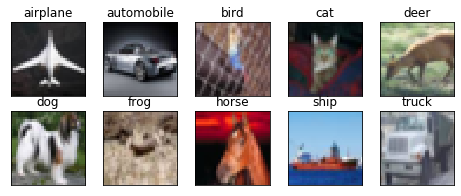

In [4]:
# Visualization of some particular classes from the dataset
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5,1 + i, xticks=[], yticks=[])
    # gets the all the position of a particular class
    idx = np.where(train_labels[:]==i)[0]
    # using the idx we can find the corresponding image arrays
    features_idx = train_features[idx,::]
    # selects an img num by random
    img_num = np.random.randint(features_idx.shape[0])
    # gets the img array by img num
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
# Normalize data
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# Convert class labels to binary class labels
train_labels = tfk.utils.to_categorical(train_labels, num_classes)
test_labels = tfk.utils.to_categorical(test_labels, num_classes)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Gradcam

In [0]:
def gradCam(img_tensors):
  preds = model.predict(img_tensors)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer("conv2d_8")
  
  heatmap_model = tfk.models.Model([model.input], [last_conv_layer.output, model.get_layer("global_average_pooling2d").output])
  with tf.GradientTape() as gtape:
      conv_output, predictions = heatmap_model(img_tensors)
      loss = predictions[:, np.argmax(predictions[0])]
      grads = gtape.gradient(loss, conv_output)
      pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
  heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = np.squeeze(heatmap)
  return heatmap

def plotHeatMap(heatmap_full,imgs,img_test_labels):
  imgs = (imgs * 255).round().astype(np.uint8)
  num_images = imgs.shape[0]
  for i in range(num_images):
    heatmap = cv2.resize(heatmap_full[i], (imgs.shape[2], imgs.shape[1]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(imgs[i], 0.6, heatmap, 0.4, 0)
    fig, axes = plt.subplots(1,2, figsize=(10, 10))
    axes[0].set_title(img_test_labels[i])
    axes[0].imshow(imgs[i])
    axes[1].set_title(img_test_labels[i])
    axes[1].imshow(superimposed_img)

### Cutout


In [0]:
# code is used from https://github.com/yu4u/cutout-random-erasing/blob/master/random_eraser.py

def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


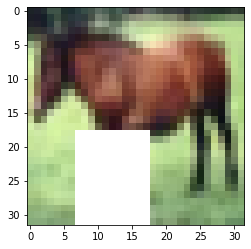

In [9]:
# test a image with cutout
eraser = get_random_eraser()

img = eraser(train_features[7])
plt.imshow(img)

### Model histopy plot functions

In [0]:
# This function plots 2 graph --> model acc(train,val) vs epoch/ model loss(train,val) vs epoch

def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

# Returns accuracy on test data

def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

### Lr Finder

In [0]:
class LR_Finder(tfk.callbacks.Callback):
    
    def __init__(self, start_lr=1e-5, end_lr=10, step_size=None, beta=.98):
        super().__init__()
        
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.step_size = step_size
        self.beta = beta
        self.lr_mult = (end_lr/start_lr)**(1/step_size)
        
    def on_train_begin(self, logs=None):
        self.best_loss = 1e9
        self.avg_loss = 0
        self.losses, self.smoothed_losses, self.lrs, self.iterations = [], [], [], []
        self.iteration = 0
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.start_lr)
        
    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        self.iteration += 1
        
        self.avg_loss = self.beta * self.avg_loss + (1 - self.beta) * loss
        smoothed_loss = self.avg_loss / (1 - self.beta**self.iteration)
        
        # Check if the loss is not exploding
        if self.iteration>1 and smoothed_loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if smoothed_loss < self.best_loss or self.iteration==1:
            self.best_loss = smoothed_loss
        
        lr = self.start_lr * (self.lr_mult**self.iteration)
        
        self.losses.append(loss)
        self.smoothed_losses.append(smoothed_loss)
        self.lrs.append(lr)
        self.iterations.append(self.iteration)
        
        
        K.set_value(self.model.optimizer.lr, lr)  
        
    def plot_lr(self):
        plt.xlabel('Iterations')
        plt.ylabel('Learning rate')
        plt.plot(self.iterations, self.lrs)
        
    def plot(self, n_skip=10):
        plt.ylabel('Loss')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_smoothed_loss(self, n_skip=10):
        plt.ylabel('Smoothed Losses')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.smoothed_losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_loss(self):
        plt.ylabel('Losses')
        plt.xlabel('Iterations')
        plt.plot(self.iterations[10:], self.losses[10:])

In [0]:
############## Build Model from 6a ###############

def build_model(filepath,lr = 0.01,momenTum = 0,deCay = 0):
    # load 6a model without the weight to train it again
    with open(filepath, "r") as f:
        loaded_model_json = f.read()
    model = tfk.models.model_from_json(loaded_model_json)
    # model.summary()
    model.compile(optimizer = tf.optimizers.SGD(lr=lr, momentum=momenTum, decay=deCay), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [0]:

################### Define the callbacks ###################

# Call lr finder to find lr
lr_finder = LR_Finder(start_lr=1e-7, end_lr=10, step_size=np.ceil(train_features.shape[0]/128))

# Create datagenerate for training
datagen = tfk.preprocessing.image.ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False,preprocessing_function=get_random_eraser(v_l=0.1, v_h=0.3))
base_dir = '/content/drive/My Drive/EVA/Session9'

filepath ='/content/drive/My Drive/EVA/Session9/model_architecture.json'
model = build_model(filepath)

In [20]:
model.save_weights('/content/drive/My Drive/EVA/Session11/saved_model.hdf5')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256   

In [21]:
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 validation_data = (test_features, test_labels), verbose=1,
                                callbacks=[lr_finder])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))

391/391 [==============================] - 76s 195ms/step - loss: 2.3904 - accuracy: 0.1416 - val_loss: 14.4907 - val_accuracy: 0.1000
Model took 76.30 seconds to train


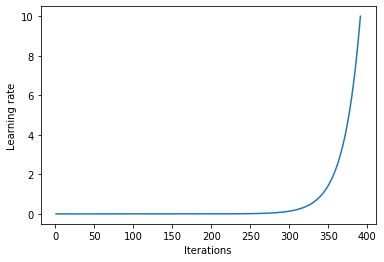

In [22]:
lr_finder.plot_lr()

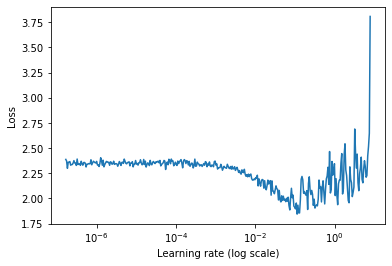

In [23]:
lr_finder.plot()

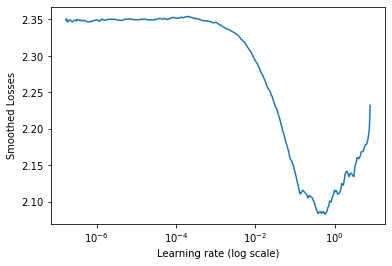

In [24]:
lr_finder.plot_smoothed_loss()

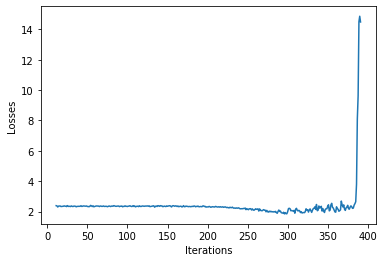

In [25]:
lr_finder.plot_loss()

### Choose lr from  10^-2 to 10^-1. Let's use .1 as lerning rate

In [0]:
################### Define the callbacks ###################

base_dir = '/content/drive/My Drive/EVA/Session11'

if not (os.path.exists(os.path.join(base_dir, 'weights'))):
    os.mkdir(os.path.join(base_dir, 'weights'))

filepath = os.path.join(base_dir,
                        'weights/weights-improvement-cutout-best.hdf5')

checkpoint = tfk.callbacks.ModelCheckpoint(filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

# Create datagenerate for training
datagen = tfk.preprocessing.image.ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False,preprocessing_function=get_random_eraser(v_l=0.1, v_h=0.3))
# build model
model_filepath = '/content/drive/My Drive/EVA/Session9/model_architecture.json'
model = build_model(model_filepath,0.5,.9,0)

In [0]:
# model.load_weights('/content/drive/My Drive/EVA/Session11/saved_model.hdf5')

In [0]:
model.compile(optimizer = tf.optimizers.SGD(lr=.1, momentum=.9, decay=0), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
start = time.time()

# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128), epochs = 100,
                                 validation_data = (test_features, test_labels), verbose=1,
                                callbacks=[checkpoint])
end = time.time()

print ("Model took %0.2f seconds to train"%(end - start))

# plot model history
plot_model_history(model_info)

# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

Epoch 1/100
390/391 [============================>.] - ETA: 0s - loss: 1.5796 - accuracy: 0.4160
Epoch 00001: val_accuracy improved from -inf to 0.53730, saving model to /content/drive/My Drive/EVA/Session11/weights/weights-improvement-cutout-best.hdf5
391/391 [==============================] - 40s 101ms/step - loss: 1.5792 - accuracy: 0.4162 - val_loss: 1.2764 - val_accuracy: 0.5373
Epoch 2/100
390/391 [============================>.] - ETA: 0s - loss: 1.2223 - accuracy: 0.5582
Epoch 00002: val_accuracy improved from 0.53730 to 0.60050, saving model to /content/drive/My Drive/EVA/Session11/weights/weights-improvement-cutout-best.hdf5
391/391 [==============================] - 39s 100ms/step - loss: 1.2220 - accuracy: 0.5583 - val_loss: 1.1253 - val_accuracy: 0.6005
Epoch 3/100
390/391 [============================>.] - ETA: 0s - loss: 1.0536 - accuracy: 0.6238
Epoch 00003: val_accuracy improved from 0.60050 to 0.68240, saving model to /content/drive/My Drive/EVA/Session11/weights/weig

In [0]:
### Loadthe best model from saved weights

In [0]:
model = tfk.models.load_model(filepath)

### Run GradCAM on the any 25 misclassified images

In [0]:
pred = model.predict(test_features)
miss_label_index = []

# if the argmax of pred doesn't match with Y_test argmax that means pred is wrong

for i, each_pred in enumerate(pred):
    if np.argmax(each_pred) != np.argmax(test_labels[i]):
        miss_label_index.append(i)

In [0]:
# Total misclassified images out of 10k X_test
print(len(miss_label_index))

1361


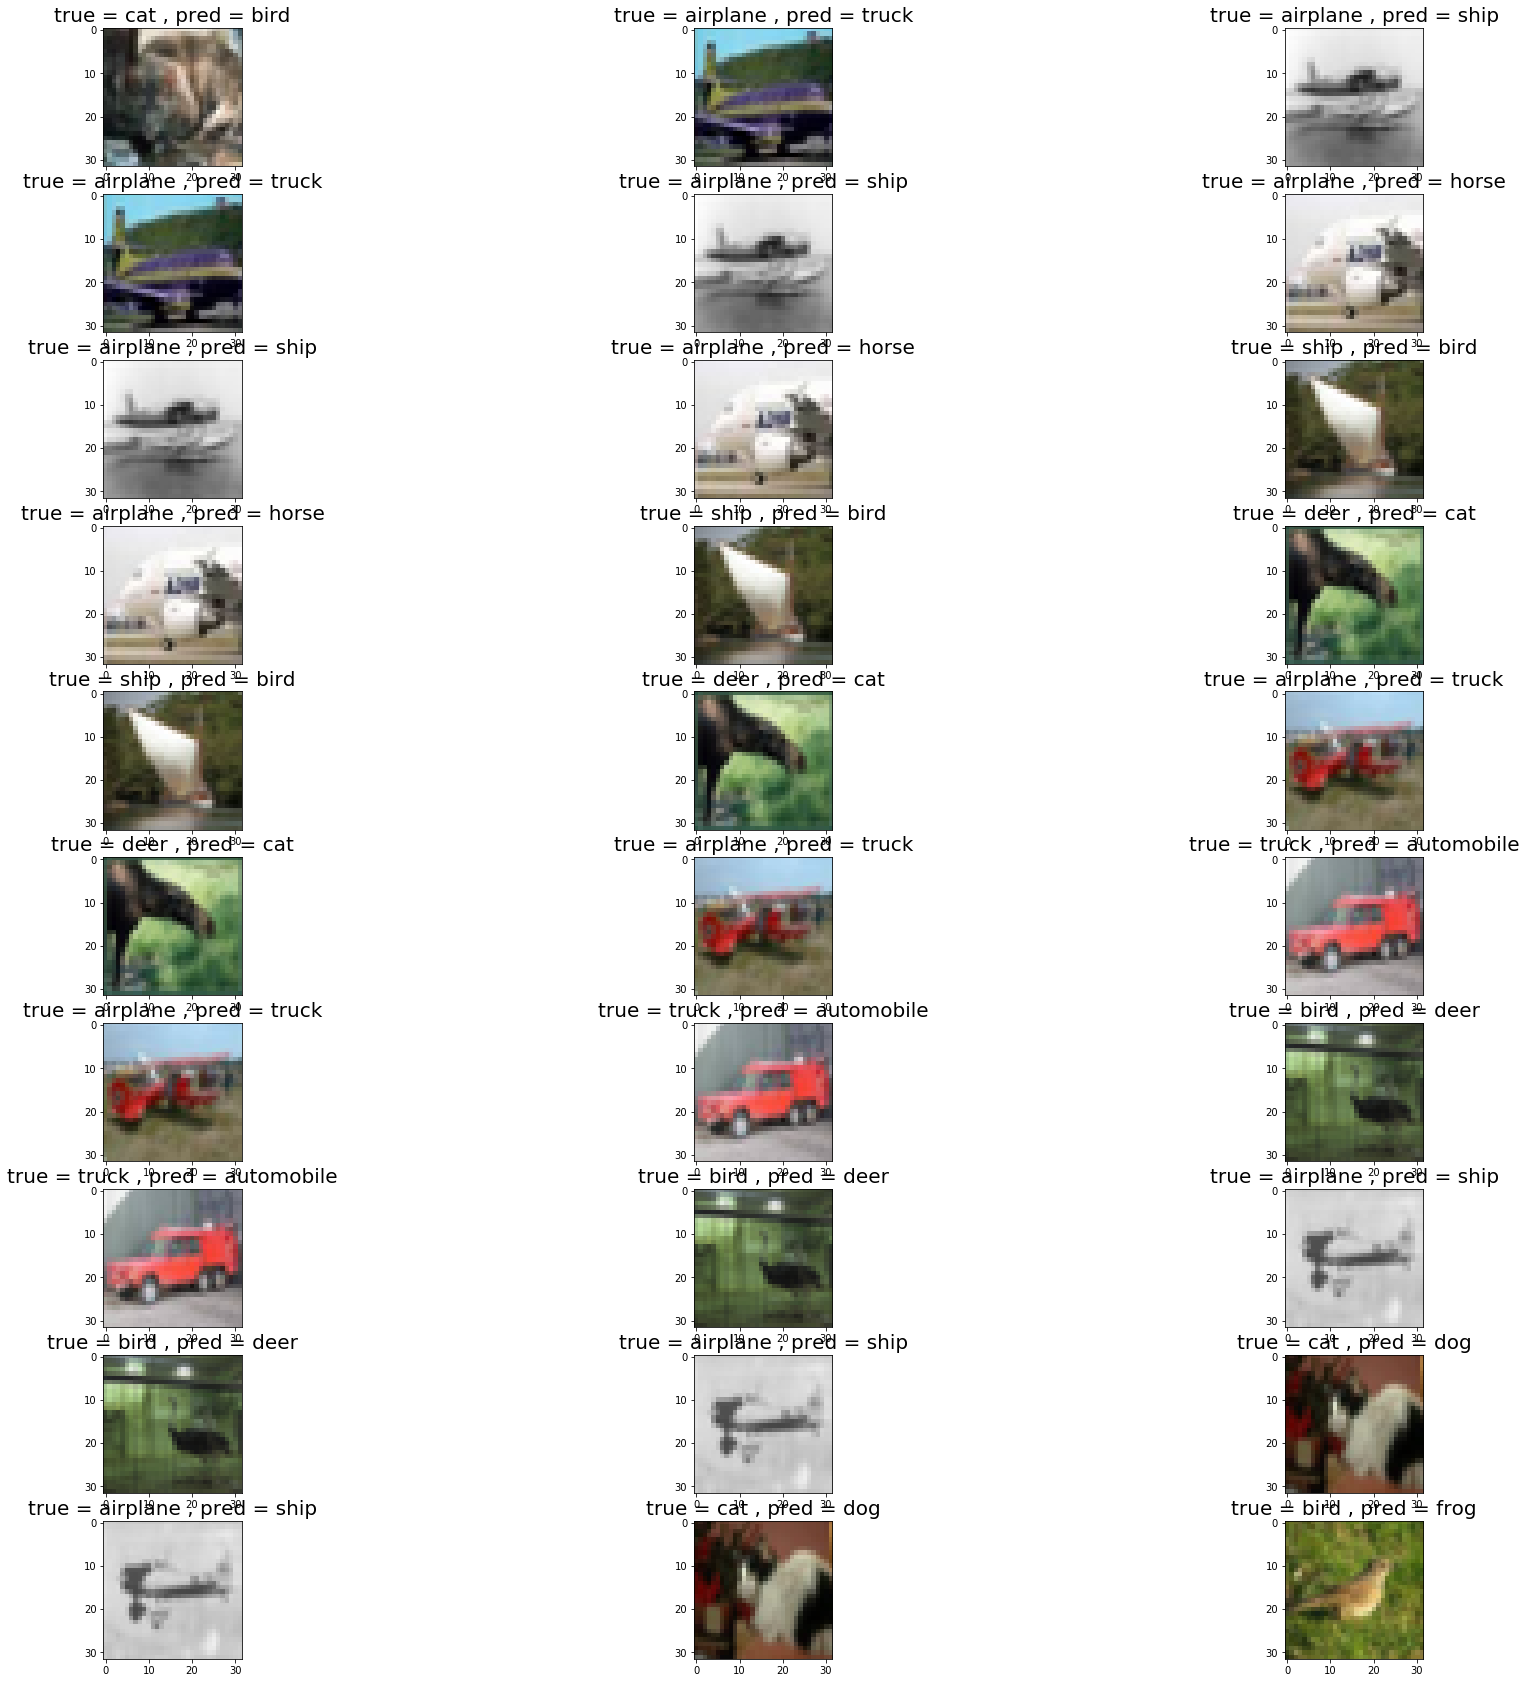

In [0]:
# random select 25 missclassified image index
miss_labels = random.sample(miss_label_index, 30)

# plot the images with true and predicted labels
fig, axes = plt.subplots(10, 3, figsize=(30, 30))
for i in range(10):
    for j in range(3):
        Y_test_true_label = np.argmax(test_labels[miss_labels[i + j]])
        Y_test_pred_label = np.argmax(pred[miss_labels[i + j]])
        X_test_image = test_features[miss_labels[i + j]]
        axes[i, j].set_title('true = ' + str(class_names[Y_test_true_label]) +' , pred = ' + str(class_names[Y_test_pred_label]),fontsize=20)
        axes[i, j].imshow((X_test_image))